# Анализ оттока клиентов банка

### Материалы:
[Презентация](https://yadi.sk/i/4zD2HZKHvSkobg)  
[Дашборд](https://public.tableau.com/profile/maria6386#!/vizhome/fp_v1/Dashboard1?publish=yes)

## Содержание

1. [Описание проекта](#step1)  
 - Задача. 
 - Описание данных. 
2. [Загрузка, первичный осмотр и предобработка данных](#step2)  
 - Проверка соответствия типов данных содержанию.  
 - Обработка пропусков. 
 - Выявление и обработка аномальных значений. 
 - Выявление и обработка дубликатов.  
 - Преобразование категориальных переменных.  
3. [Формирование типичных портретов клиентов, склонных к оттоку](#step3)  
 - Изучение средних значений и распределений признаков в группах ушедших и оставшихся клиентов.
 - Кластеризация клиентов, оценка качества кластеризации. Изучение признаков, сравнение доли оттока в различных кластерах.  
 - Описание клиентов, склонных к оттоку.  
4. [Проверка статистических гипотез](#step4)
5. [Выводы и рекомендации](#step5)

<a id='step1'></a>
## 1. Описание проекта  

**Задача:**  
Выделить портрет клиентов, которые склонны уходить из банка.  

**Данные:**  
Данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.  

- `userid` — идентификатор пользователя,  
- `score` — баллы кредитного скоринга,  
- `City` — город,  
- `Gender` — пол,  
- `Age` — возраст,  
- `Objects` — количество объектов в собственности,  
- `Balance` — баланс на счёте (среднее за последние 30 дней),  
- `Products` — количество продуктов, которыми пользуется клиент,  
- `CreditCard` — есть ли кредитная карта,  
- `Loyalty` — активный клиент,  
- `estimated_salary` — заработная плата клиента,  
- `Churn` — ушёл или нет.  

<a id='step2'></a>
## 2. Загрузка, первичный осмотр и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import math
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


mpl.rcParams['figure.figsize'] = (12,6)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import warnings
warnings.simplefilter('ignore')

In [2]:
try:
    data = pd.read_csv('datasets/bank_dataset.csv')
except:
    data = pd.read_csv('/datasets/bank_dataset.csv')
init_data = data.copy()

In [3]:
data.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# для удобства переведем названия столбцов внижний регистр.
data.columns = data.columns.str.lower()

В данных имеются числовые, бинарные и категориальные признаки. 

In [5]:
numeric_values = ['score', 'age', 'objects', 'balance', 'products', 'estimated_salary']
numeric_names = ['Баллы кредитного скоринга', 'Возраст', 
                 'Количество объектов в собственности', 'Баланс на счете', 
                'Количество используемых продуктов', 'Заработная плата']
binary_values = ['creditcard', 'loyalty', 'churn']
binary_names = ['Есть ли кредитная карта', 'Активен ли клиент', 'Ушел или нет']
cat_values = ['city', 'gender']
cat_names = ['Город', 'Пол']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
city                10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
objects             10000 non-null int64
balance             6383 non-null float64
products            10000 non-null int64
creditcard          10000 non-null int64
loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Доступны данные о 10000 клиентах.  
Переведем `user_id` в строковый тип. Остальные типы данных соответствуют содержанию столбцов.

In [7]:
data['userid'] = data['userid'].astype('str')

Видно, что в достаточно много пропусков есть в столбце `balance`. Посчитаем процент от общего количества данных. 

In [8]:
print('Данные о балансе пропущены у {:.2%} клиентов'.format(
    data[data['balance'].isna()].shape[0]/data.shape[0]))

Данные о балансе пропущены у 36.17% клиентов


In [9]:
data[data['balance'].isna()].describe()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,3617.000000,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,649.452861,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236
std,96.158798,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195
min,350.000000,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000
25%,583.000000,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000
50%,651.000000,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000
75%,717.000000,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000
max,850.000000,88.000000,10.000000,NaN,4.000000,1.000000,1.000000,199992.480000,1.000000


In [10]:
data[~data['balance'].isna()].describe()

,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
count,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000
mean,651.138493,39.197713,4.979633,119827.493793,1.386025,0.699201,0.513552,100717.352956,0.240796
std,96.934609,10.476208,2.909514,30095.056462,0.577011,0.458641,0.499855,57380.316584,0.427600
min,350.000000,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,100181.975000,1.000000,0.000000,0.000000,51736.850000,0.000000
50%,652.000000,38.000000,5.000000,119839.690000,1.000000,1.000000,1.000000,101139.300000,0.000000
75%,718.000000,44.000000,8.000000,139512.290000,2.000000,1.000000,1.000000,149596.615000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199970.740000,1.000000


Нельзя сказать, чтобы клиенты с пропусками в балансе как-то резко отличались от тех, у кого баланс заполнен. Выделять клиентов с пропусками в отдельную категорию нет смысла.  
Попробуем заполнить пропуски каким-то типичным значением.  
Исследуем подробнее взаимосвязь баланса с остальными переменными.  

In [11]:
data_no_na = data[~data['balance'].isna()]
data_no_na[numeric_values].corr()

,score,age,objects,balance,products,estimated_salary
score,1.000000,-0.009476,0.002884,-0.004744,0.008894,0.000570
age,-0.009476,1.000000,0.009221,-0.012822,0.007565,-0.008592
objects,0.002884,0.009221,1.000000,0.005827,0.006457,0.012609
balance,-0.004744,-0.012822,0.005827,1.000000,-0.001027,-0.001856
products,0.008894,0.007565,0.006457,-0.001027,1.000000,0.025769
estimated_salary,0.000570,-0.008592,0.012609,-0.001856,0.025769,1.000000


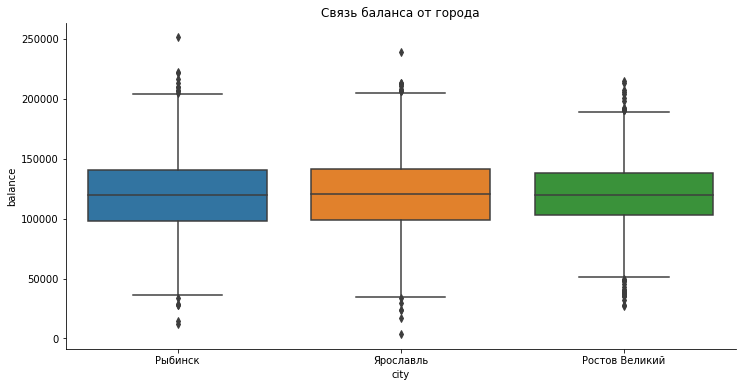

In [12]:
sns.boxplot(x='city', y='balance', data=data_no_na)
plt.title('Связь баланса от города');

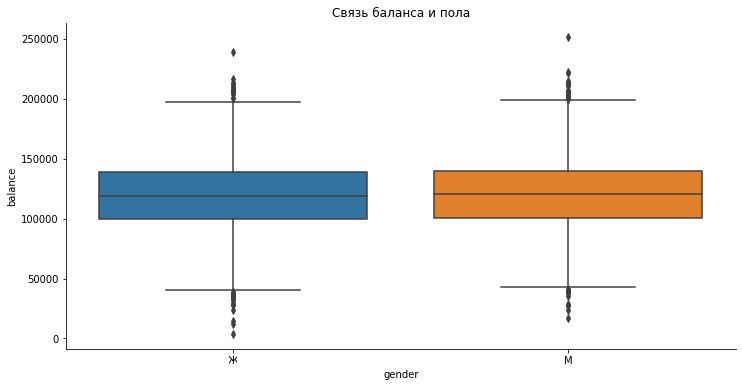

In [13]:
sns.boxplot(x='gender', y='balance', data=data_no_na)
plt.title('Связь баланса и пола');

Можно было предположить, что баланс связан, например, с доходом, и заполнить пропуски средними по категориям дохода. Но судя по таблице и графикам выше, баланс не коррелирует ни с доходом, ни с какими-то другими переменными, так что заполним пропуски одним характерным значением.

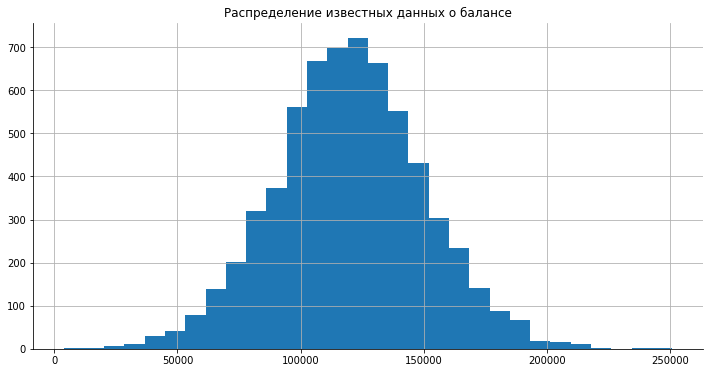

In [14]:
data_no_na['balance'].hist(bins=30)
plt.title('Распределение известных данных о балансе');

Распределение похоже на нормальное, так что заполним пропуски средним значением:

In [15]:
balance_filled = data['balance'].fillna(data['balance'].mean())
data['balance'] = balance_filled

Проверим данные на наличие дубликатов.

In [16]:
data.duplicated().sum()

0

Грубых дубликатов нет. Посмотрим на уникальные значения категориальных переменных, чтобы выявить скрытые дубликаты и пропуски.

In [17]:
data['gender'].unique()

array(['Ж', 'М'], dtype=object)

In [18]:
data['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

Скрытых дубликатов и пропусков не обнаружено.

Посмотрим, нет ли в данных аномальных значений.

In [19]:
data[numeric_values].describe()

,score,age,objects,balance,products,estimated_salary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,119827.493793,1.530200,100090.239881
std,96.653299,10.487806,2.892174,24043.366590,0.581654,57510.492818
min,350.000000,18.000000,0.000000,3768.690000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,111581.127500,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,119827.493793,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


Значения всех переменных кроме `estimated_salary` выглядят правдоподобно. Рассмотрим данные о заработной плате подробнее. 

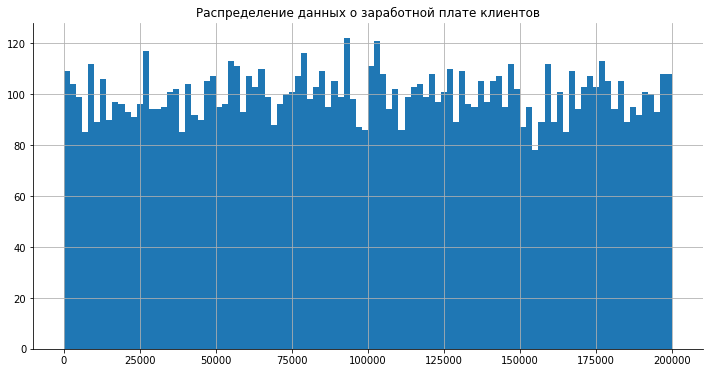

In [20]:
data['estimated_salary'].hist(bins=100)
plt.title('Распределение данных о заработной плате клиентов');

Данные о заработной плате выглядят очень странно. Распределение доходов клиентов должно напоминать нормальное, скошенное вправо, в случае VIP-клиентов, сдвинутое в сторону больших значений. В данном случае это скорее равномерное распределение:

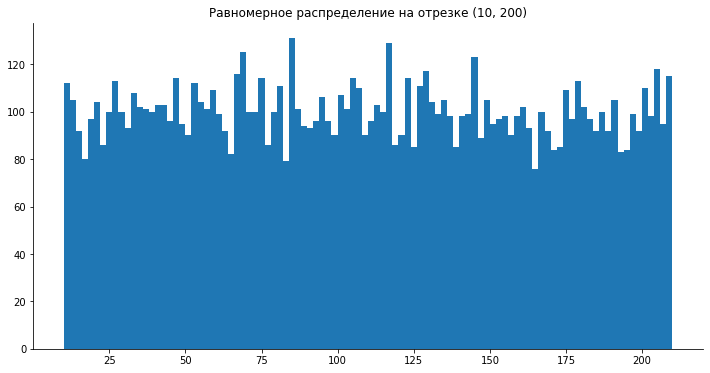

In [21]:
plt.hist(st.uniform(10,200).rvs(10000), bins=100)
plt.title('Равномерное распределение на отрезке (10, 200)');

Слово `estimated` намекает на то, что данные были определенным образом оценены, а не предоставлены клиентами. Я думаю, следует исключить данные из анализа и разобраться, как именно они были получены и в чем может быть ошибка. 

In [22]:
data = data.drop('estimated_salary', axis=1)

В данных есть категориальные переменные. Для целей кластеризации их нужно будет преобразовать в числовые, что мы и сделаем.

In [23]:
# пол можно закодировать без применения специальных функций.
# обозначим женщин через 0 и мужчин через 1
data_encoded = data
data_encoded.loc[data['gender']=='Ж', 'gender'] = 0
data_encoded.loc[data['gender']=='М', 'gender'] = 1
data_encoded['gender'] = data_encoded['gender'].astype('int')

In [24]:
city_encoded = pd.get_dummies(data['city'])

In [25]:
data_encoded = pd.concat([data_encoded.drop('city', axis=1),
                         city_encoded], axis=1)

In [26]:
data_encoded.head()

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,churn,Ростов Великий,Рыбинск,Ярославль
0,15677338,619,0,42,2,119827.493793,1,1,1,1,0,0,1
1,15690047,608,0,41,1,83807.860000,1,0,1,0,0,1,0
2,15662040,502,0,42,8,159660.800000,3,1,0,1,0,0,1
3,15744090,699,0,39,1,119827.493793,2,0,0,0,0,0,1
4,15780624,850,0,43,2,125510.820000,1,1,1,0,0,1,0


**Выводы по предобработке данных:**  
- Доступны данные о 10000 клиентах. 
- Переменная `userid` переведена в строковый тип. 
- Пропуски в переменной `balance` заполнены средним значением. 
- Дубликатов в данных не обнаружено. 
- Переменная `estimated_salary` признана непригодной для использования в дальнейшем анализе и исключена из данных. 
- Переменные `gender` и `city` закодированы числами для применения алгоритмов кластеризации.   

[К содержанию](#Содержание)

<a id='step3'></a>
## 3. Формирование типичных портретов клиентов, склонных к оттоку

**Изучение средних значений и распределений признаков в группах ушедших и оставшихся клиентов.**

In [27]:
data.groupby('churn').agg({'userid':'count'})

,userid
churn,
0,7963
1,2037


Лояльных клиентов примерно в четыре раза больше.

Посмотрим на средние значения признаков в двух группах: тех, кто ушел и тех, кто остался.

In [28]:
average_in_groups = data_encoded.groupby('churn').mean()
average_in_groups = average_in_groups.T
average_in_groups['difference'] = abs(((average_in_groups[0] - average_in_groups[1])/\
average_in_groups[0]).round(2))
average_in_groups.sort_values('difference', ascending=False)

churn,0,1,difference
Ростов Великий,0.212859,0.399607,0.88
loyalty,0.554565,0.360825,0.35
Ярославль,0.527942,0.397644,0.25
gender,0.572523,0.440844,0.23
Рыбинск,0.259199,0.202749,0.22
age,37.408389,44.837997,0.20
products,1.544267,1.475209,0.04
objects,5.033279,4.932744,0.02
score,651.853196,645.351497,0.01
balance,119650.018385,120521.277136,0.01


По данной таблице можно сделать вывод, что группы ушедших и оставшихся клиентов имеют существенные различия по таким характеристикам, как:  
- город;
- активность;  
- возраст.

Построим гистограммы распределения числовых признаков.

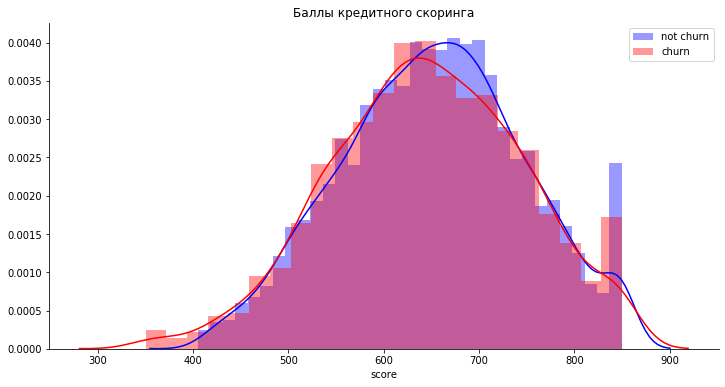

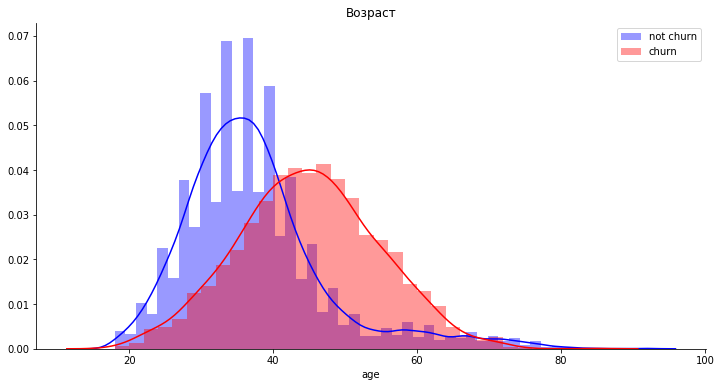

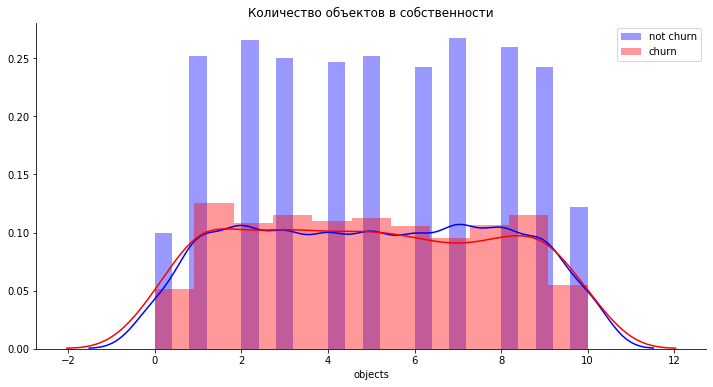

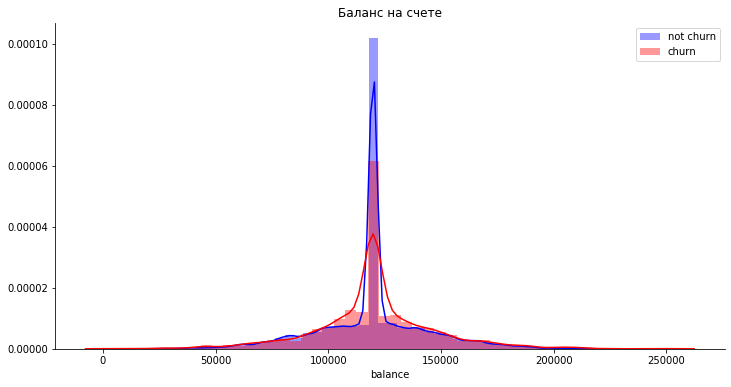

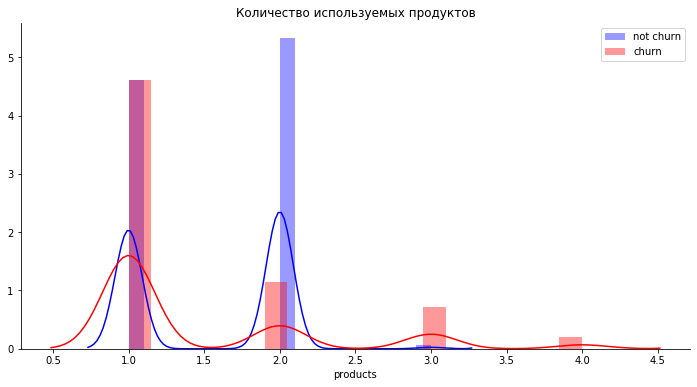

In [29]:
numeric_values.remove('estimated_salary')
for i in range(len(numeric_values)):
    plt.figure(figsize=(12,6))
    plt.title(numeric_names[i])
    sns.distplot(data_encoded.loc[data['churn']==0, numeric_values[i]],
                                   color='blue', label='not churn')
    sns.distplot(data_encoded.loc[data['churn']==1, numeric_values[i]],
                                   color='red', label='churn')
    plt.legend()

In [30]:
data.loc[data['churn']==1, 'products'].value_counts()

1    1409
2     348
3     220
4      60
Name: products, dtype: int64

In [31]:
data.loc[data['churn']==0, 'products'].value_counts()

2    4242
1    3675
3      46
Name: products, dtype: int64

Выводы:  
- Распределения баллов кредитного скоринга в двух группах практически совпадают;   
- Судя по распределению возраста клиентов, ушедшие в целом немного старше;  
- Баланс на счете в двух группах различается слабо;
- Ушедшие клиенты в основном пользовались одним продуктом, но среди них, в отличие от лояльных клиентов, есть и те, у кого количество продуктов превышает 3.

Посмотрим на соотношение бинарных признаков.

In [32]:
binary_values.remove('churn')
binary_names.remove('Ушел или нет')
binary_values.append('gender')
binary_names.append('Пол')

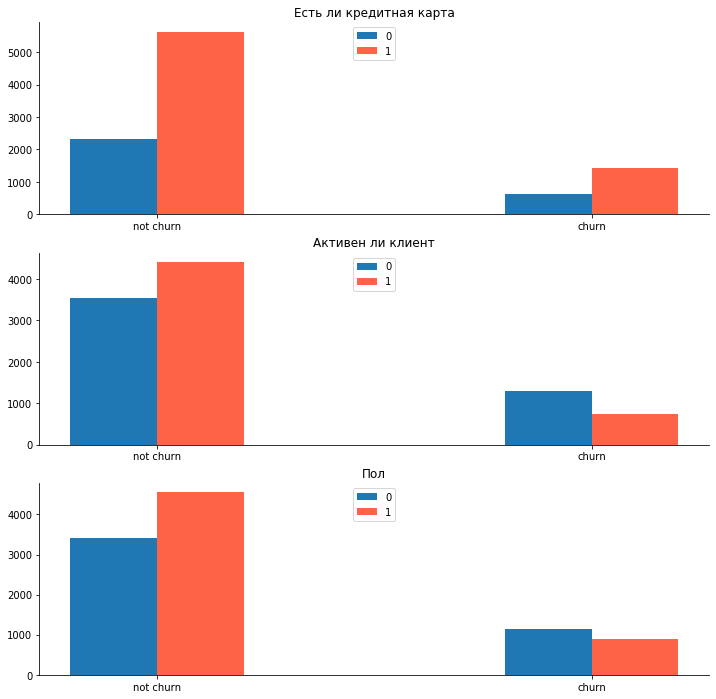

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12,12))

for i in range(len(binary_values)):
    df1 = data.loc[data[binary_values[i]]==0, 'churn'].value_counts().sort_index()
    df2 = data.loc[data[binary_values[i]]==1, 'churn'].value_counts().sort_index()
    x_pos1 = [0,1]
    x_pos2 = [0.2, 1.2]
    axes[i].bar(x_pos1, df1.values, label='0', width=0.2)
    axes[i].bar(x_pos2, df2.values, color='tomato', label='1', width=0.2)
    axes[i].set_xticks([x+0.1 for x in x_pos1])
    axes[i].set_xticklabels(['not churn', 'churn'])
    axes[i].legend(loc='upper center')
    axes[i].set_title(binary_names[i]);

 - Среди ушедших клиентов меньше активных;  
 - Среди оставшихся клиентов больше мужчин.

Посмотрим на распределение ушедших и оставшихся клиентов по городам.

In [34]:
churn_in_cities = data.pivot_table(index='city', columns='churn', values='userid',
                                  aggfunc='count')
churn_in_cities

churn,0,1
city,,
Ростов Великий,1695,814
Рыбинск,2064,413
Ярославль,4204,810


In [35]:
grouped_by_city = data.groupby('city').agg({'churn':'mean'}).round(2)
grouped_by_city

,churn
city,
Ростов Великий,0.32
Рыбинск,0.17
Ярославль,0.16


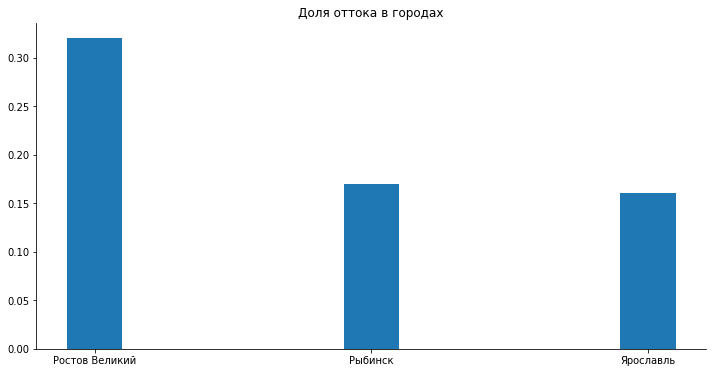

In [36]:
plt.bar(grouped_by_city.index, grouped_by_city.churn, width=0.2)
plt.title('Доля оттока в городах');

В Ростове Великом доля оттока почти в два раза превышает этот показатель в Ярославле и Рыбинске.

**Кластеризация клиентов, оценка качества кластеризации. Изучение признаков, сравнение доли оттока в различных кластерах.**

In [37]:
data_encoded.head()

,userid,score,gender,age,objects,balance,products,creditcard,loyalty,churn,Ростов Великий,Рыбинск,Ярославль
0,15677338,619,0,42,2,119827.493793,1,1,1,1,0,0,1
1,15690047,608,0,41,1,83807.860000,1,0,1,0,0,1,0
2,15662040,502,0,42,8,159660.800000,3,1,0,1,0,0,1
3,15744090,699,0,39,1,119827.493793,2,0,0,0,0,0,1
4,15780624,850,0,43,2,125510.820000,1,1,1,0,0,1,0


In [38]:
X = data_encoded.drop(['userid', 'churn'], axis=1)

Приведем признаки к единому масштабу.

In [39]:
scaler = StandardScaler()

In [40]:
X_st = scaler.fit_transform(X)

Определим оптимальное количество кластеров с помощью алгоритма иерархической агломеративной кластеризации.

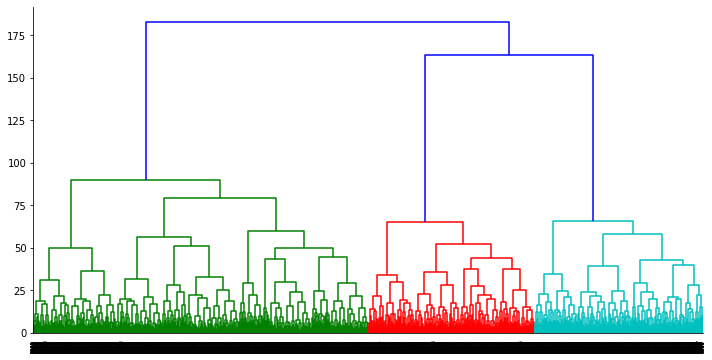

In [41]:
linked = linkage(X_st, method='ward')
dendrogram(linked, orientation='top');

Данные целесообразно поделить на три кластера.   
Применим алгоритм kmeans.

In [42]:
km = KMeans(n_clusters=3, random_state=0)

In [43]:
labels = km.fit_predict(X_st)

Проверим качество кластеризации с помощью метрики силуэта.

In [44]:
silhouette_score(X_st, labels)

0.22019978507621923

Учитывая, что коэффициент силуэта принимает значения в диапазоне от -1 до 1, полученное значение не очень велико.   
Посмотрим, имеет ли такое разделение на кластеры практический смысл.

In [45]:
X['cluster'] = labels
X['churn'] = data_encoded['churn']

Посмотрим на средние значения признаков для класеров.

In [46]:
X.groupby('cluster').mean()

,score,gender,age,objects,balance,products,creditcard,loyalty,Ростов Великий,Рыбинск,Ярославль,churn
cluster,,,,,,,,,,,,
0,649.668329,0.549063,38.511767,5.004587,119879.409550,1.530913,0.706621,0.516753,0,0,1,0.161548
1,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,1,0,0,0.324432
2,651.333872,0.560355,38.890997,5.032297,119821.040399,1.539362,0.694792,0.529673,0,1,0,0.166734


Похоже, что алгоритм машинного обучения подтвердил наше предположение и объединил кластеры по признаку города. Ростов Великий явно имеет проблемы с лояльностью клиентов.

**Вывод:**  
 Клиенты, склонные к оттоку, обладают следующими характеристиками:  
 - в среднем несколько старше по возрасту;  
 - ниже доля активности;  
 - больше доля женщин;  
 - пользуются большим числом продуктов.   
 
Выявлена проблема с оттоком в городе Ростов Великий.  

[К содержанию](#Содержание)

<a id='step4'></a>
## 4. Проверка статистических гипотез

In [47]:
alpha = 0.05

**1. Доля оттока в Ростове Великом отличается от доли оттока в других городах**

Гипотеза $H_0$: Доля оттока в Ростове Великом не отличается от доли оттока в других городах.  
Гипотеза $H_1$: Доля оттока в Ростове Великом отличается от доли оттока в других городах.

Используем z-критерий для разности долей.

In [48]:
data['city_for_hypothesis_test'] = np.where(data['city']=='Ростов Великий',
                                           'Ростов Великий', 'Другой город')

In [49]:
grouped = data.groupby('city_for_hypothesis_test').agg({'churn':['mean', 'count']})
grouped.columns = ['churn_rate', 'total_users']
grouped

,churn_rate,total_users
city_for_hypothesis_test,,
Другой город,0.163263,7491
Ростов Великий,0.324432,2509


In [50]:
pivot = data.pivot_table(index='city_for_hypothesis_test', 
                        columns='churn', values='userid', aggfunc='count')
pivot = pivot.merge(grouped, left_index=True, right_index=True)
pivot

,0,1,churn_rate,total_users
city_for_hypothesis_test,,,,
Другой город,6268,1223,0.163263,7491
Ростов Великий,1695,814,0.324432,2509


In [51]:
p1 = pivot.loc['Ростов Великий', 'churn_rate']
p2 = pivot.loc['Другой город', 'churn_rate']
p_combined = (pivot.loc['Ростов Великий', 1] + pivot.loc['Другой город', 1])/\
(pivot.loc['Ростов Великий', 'total_users'] + pivot.loc['Другой город', 'total_users'])
diff = p1 - p2
z_value = diff/\
math.sqrt(p_combined*(1 - p_combined) * ((1/pivot.loc['Ростов Великий', 'total_users']) + 
                                         (1/pivot.loc['Другой город', 'total_users'])))
distr = st.norm(0,1)
p_value = (1 - distr.cdf(abs(z_value)))*2

In [52]:
print('p-значение: {:.5f}'.format(p_value))
if p_value < alpha:
    print('Отвергаем H0.')
    print()
else:
    print('Не отвергаем H0.')
    print()

p-значение: 0.00000
Отвергаем H0.



**2. Средний возраст в группе ушедших клиентов отличается от среднего возраста оставшихся клиентов**

Гипотеза $H_0$: Средний возраст ушедших и оставшихся клиентов не отличается.  
Гипотеза $H_1$: Средний возраст ушедших и оставшихся клиентов отличается.

Гипотезу о равенстве средних будем проверять с помощью t-теста Стьюдента.  

In [53]:
results = st.ttest_ind(data.loc[data['churn']==0, 'age'],
                      data.loc[data['churn']==1, 'age'],
                      equal_var=False)

In [54]:
print('p-значение: {:.5f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем H0.')
    print()
else:
    print('Не отвергаем H0.')
    print()

p-значение: 0.00000
Отвергаем H0.



**Вывод:**  
Статистическая значимость выявлена:  
 - в разности долей оттока в Ростове Великом и других городах;  
 - в среднем возрасте ушедших и оставшихся клиентов.

[К содержанию](#Содержание)

## 5. Выводы и рекомендации

1. В ходе разведочного анализа выявлена проблема с переменной `estimated_salary`. Необходимо проверить правильность алгоритма получения этих данных.  
2. В городе Ростове Великом доля оттока почти в два раза выше, чем в двух других рассмартиваемых городах, и эта разница является статистически значимой. При этом нет серьезных различий в средних значениях остальных характеристик между городами. Необходимо проверить качество работы подразделений и обслуживания клиентов именно в Ростове.
3. Клиенты в оттоке в среднем старше и среди них больше доля женщин. 
4. Среди ушедших клиентов меньше активных. Необходимо обратить особое внимание на клиентов, которые за последний месяц не взаимодействовали с банком. 
4. Многие клиенты из тех, кто использует три продукта и все, кто использует четыре продукта, оказались в оттоке. Вероятно есть определенные продукты, которые вызывают особое недовольство клиентов. Их нужно выявить и детально изучить процесс взаимодействия с ними клиентов.  

[К содержанию](#Содержание)